## Loading packages and setting up Jupyter note book

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set ()

import pdb 

In [2]:
# sets up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)


## Inspecting data files

The data come in separate csv files that contain from a quarter up to multiple years of records. Let's inspect the individual files in the shell before importing them into pandas. 

In [3]:
!head -3 *.csv

==> LoanStats3a_securev1.csv <==
Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","earliest_cr_line","fico_range_low","fico_range_high","inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d","last_fico_range_high","last_fico_range_low","collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type","annual_inc_joint","dti

This reveals that the first line contains comments and should thus be discarded when importing the data. The column names start in the second line.

## Importing data

In [4]:
files = !ls *.csv
df_list = []
for file in files:
    df_list.append(pd.read_csv(file, header=1, low_memory=False))

all_data = pd.concat(df_list)  

Before we go on to inspect the data, let us zoom in on only the relevant observations.  To that end, let us take a look at the variable of interest, loan_status:

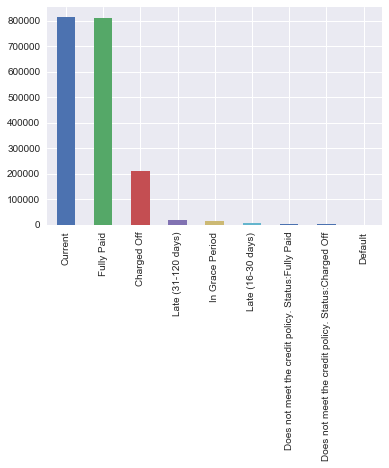

In [5]:
all_data.loan_status.value_counts().plot(kind = "bar")

The main question we need to decide is how to define the outcome.  I opt for a dichotomous classification into "fully paid" versus "charged off" and "default". Note that those two classes are imbalanced.

There is a small number of loans for which the state is contains the string "does not meet the credit policy" in addition to whether it is fully paid or charged-off. Unfortunately, there is no explanation anywhere what this means. I will simply treat them as fully paid or charged off and ignore the information about not meeting the credit policy. This seems to be a separate variable, but I do not use it for prediction because it is likely that this information only became available after the loan was issued.   

Loans which are late – whether they are in the grace period or up to 120 days late – will be discarded, because their status is yet indeterminate.  We have enough observation already, and thus any gain in accuracy from these additional observations would most likely be more than offset by the increase in variance due to greater measurement error, because we simply do not have enough information yet to accurately classify them.

For similar reasons, I will discard loans That are still current.

In [6]:
# Create target variable
all_data['good'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'good'] = 1  # "Good" loans
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|(all_data.loan_status=='Default')), 'good'] = 0  # "Bad" loans

In [7]:
# Drop loans with indeterminate status
all_data = all_data.loc[all_data.good.notnull(),:]

In [8]:
type(all_data)

pandas.core.frame.DataFrame

Now that we have discarded irrelevant rows, let's discard constant columns, as well as columns for which all observations are missing:

In [9]:
# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns if all_data.loc[:,col].value_counts().shape[0]<=1] 

# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

## Exploratory Data Analysis
Now that we have discarded irrelevant rows and columns, let us take a closer look at the data. Firstly, let's see what percentage of each column is missing.

Text(0.5,0,'Percent Missing')

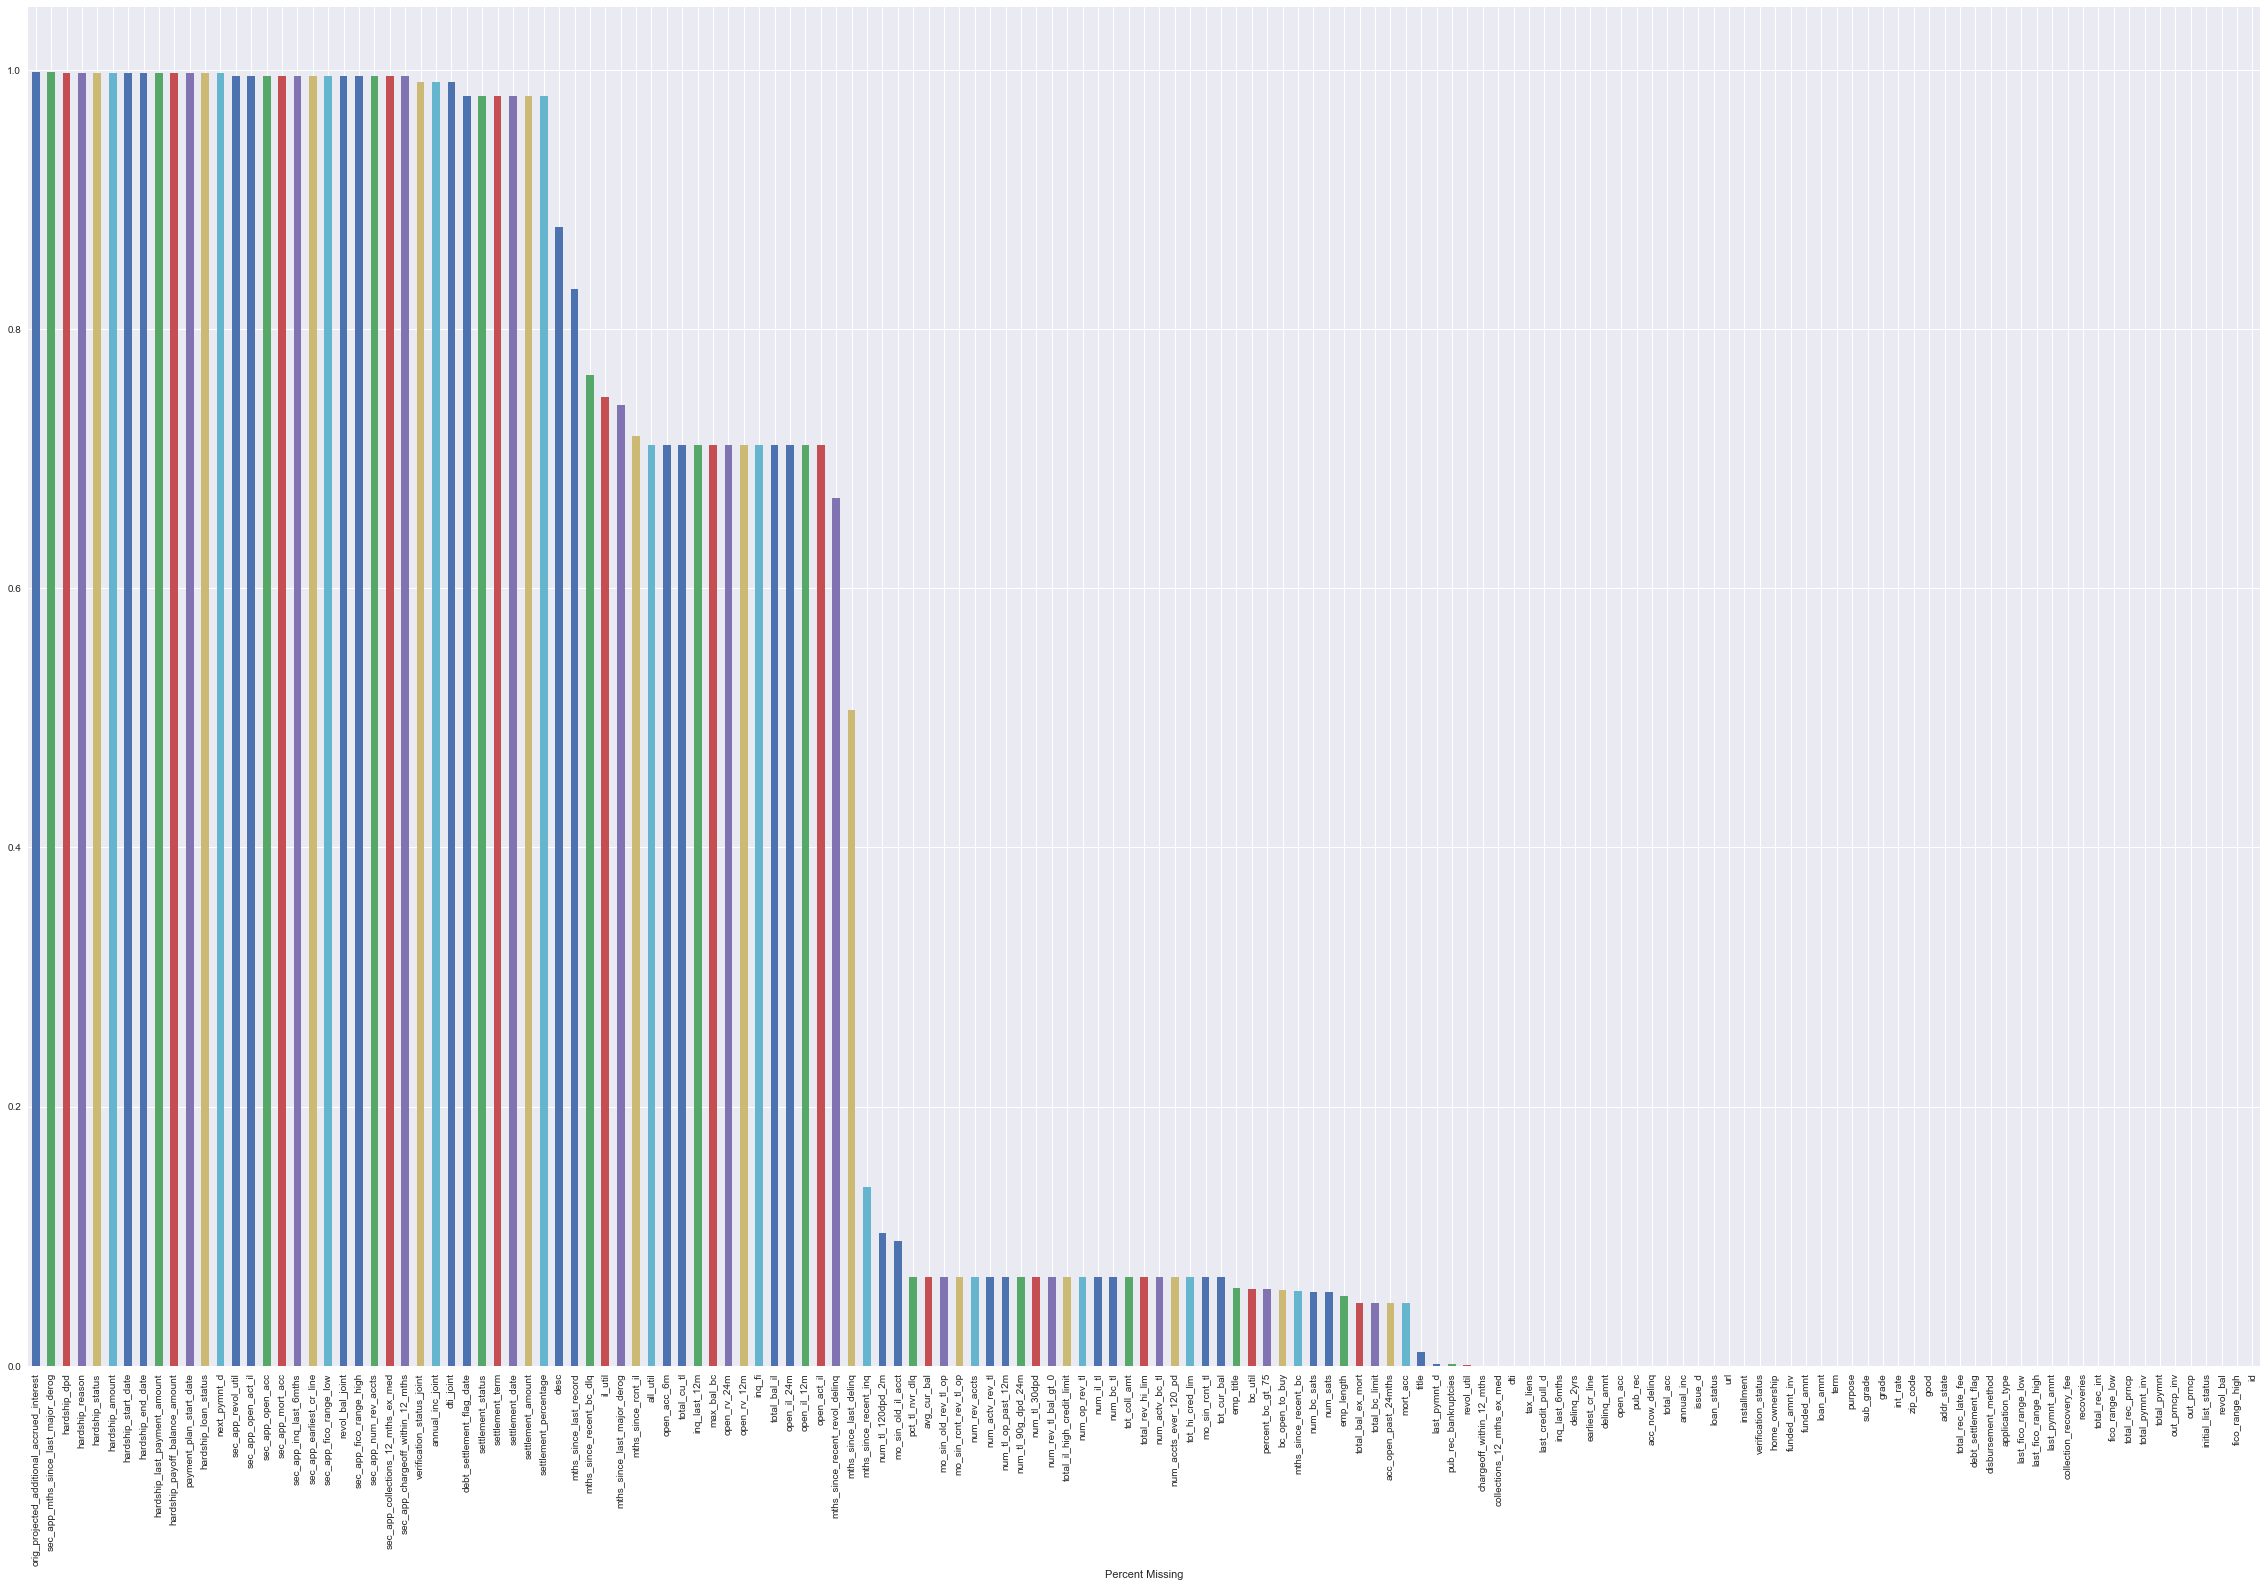

In [24]:
fig, ax = plt.subplots(figsize=(40, 25)) 
(all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False).plot(kind="bar")
ax.set_xlabel('Percent Missing')